# Stability and Performance Analysis
This notebook evaluates the robustness of the XGBoost regressor on the rogue wave dataset by repeating the best-performing model across stratified folds and analysing the resulting error metrics and target distributions.

**Imports**

In [1]:
import sys
import time
import pandas as pd

from collections import Counter
from xgboost import XGBRegressor  
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../scripts/')
import utils

**Data Loading**

In [2]:
# Data file
file_data = '../data/abin_matrix_full_encoded.csv'

# Thresholds
threshold_upper_limit = 2.7
threshold_non_rogue_wave = 1.5
threshold_rogue_wave = 2.0

# Features and target
target = 'AI_10min'
target_cat = 'AI_10min_cat'
features = ['H_s', 'lambda_40', 'lambda_30', 'L_deep', 's', 'mu', 'kh', 'T_p','nu', 'Q_p', 'BFI', 'r', 'v_wind', 'v_gust', 'T_air', 'p', 'Delta_p_1h']

In [3]:
data_rogue_waves = pd.read_csv(file_data)

data_rogue_waves = data_rogue_waves.loc[data_rogue_waves.AI_10min < threshold_upper_limit]
data_rogue_waves = data_rogue_waves.loc[:,[target]+features]

data_rogue_waves_class = data_rogue_waves.copy()
data_rogue_waves_class[target_cat] = data_rogue_waves_class[target].apply(lambda x: 0 if x < threshold_non_rogue_wave else (1 if x < threshold_rogue_wave else 2))
data_rogue_waves_class[target_cat] = data_rogue_waves_class[target_cat].astype(int)

X = data_rogue_waves_class.drop(columns=["AI_10min", "AI_10min_cat"])
y = data_rogue_waves_class["AI_10min"]
y_cat = data_rogue_waves_class["AI_10min_cat"]

**Stability Analysis**

In [4]:
# Dataset stability configurations
num_cv = 5
seed = 42

# XGBoost hyperparameters for best model
colsample_bytree = 0.8
gamma = 0
learning_rate = 0.1
max_depth = 20
min_child_weight = 1
n_estimators = 100
reg_alpha = 0
reg_lambda = 1
subsample = 0.5

In [5]:
skf = StratifiedKFold(n_splits=num_cv, random_state=seed, shuffle=True)

targets_test = {}

for i, (train_index, test_index) in enumerate(skf.split(X, y_cat)):
    fold = i+1
    print(f"########### Fold {fold} ###########")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

    targets_test[f"Distribution for test set target of fold {fold}"] = y_test

    print('-----------------------------------')
    print('Training dataset target distribution:')
    print(Counter(y_cat.iloc[train_index]))
    print('-----------------------------------')
    print('Test dataset target distribution:')
    print(Counter(y_cat.iloc[test_index]))
    print('-----------------------------------')

    model = XGBRegressor(random_state=seed, colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight,
                         n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda, subsample=subsample)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_true = y_test

    mse = round(mean_squared_error(y_true, y_pred), 3)
    mae = round(mean_absolute_error(y_true, y_pred), 3)
    r2 = round(r2_score(y_true, y_pred), 3)
    spearman_r = round(spearmanr(y_true, y_pred).correlation, 3)

    print(f"$MSE={mse}$\n$MAE={mae}$\n$R^2={r2}$\n$Spearman\\ R={spearman_r}$ \n")

########### Fold 1 ###########
-----------------------------------
Training dataset target distribution:
Counter({1: 489544, 0: 334909, 2: 14264})
-----------------------------------
Test dataset target distribution:
Counter({1: 122387, 0: 83727, 2: 3566})
-----------------------------------
$MSE=0.001$
$MAE=0.016$
$R^2=0.964$
$Spearman\ R=0.98$ 

########### Fold 2 ###########
-----------------------------------
Training dataset target distribution:
Counter({1: 489545, 0: 334908, 2: 14264})
-----------------------------------
Test dataset target distribution:
Counter({1: 122386, 0: 83728, 2: 3566})
-----------------------------------
$MSE=0.001$
$MAE=0.016$
$R^2=0.964$
$Spearman\ R=0.98$ 

########### Fold 2 ###########
-----------------------------------
Training dataset target distribution:
Counter({1: 489545, 0: 334908, 2: 14264})
-----------------------------------
Test dataset target distribution:
Counter({1: 122386, 0: 83728, 2: 3566})
-----------------------------------
$MSE=0.

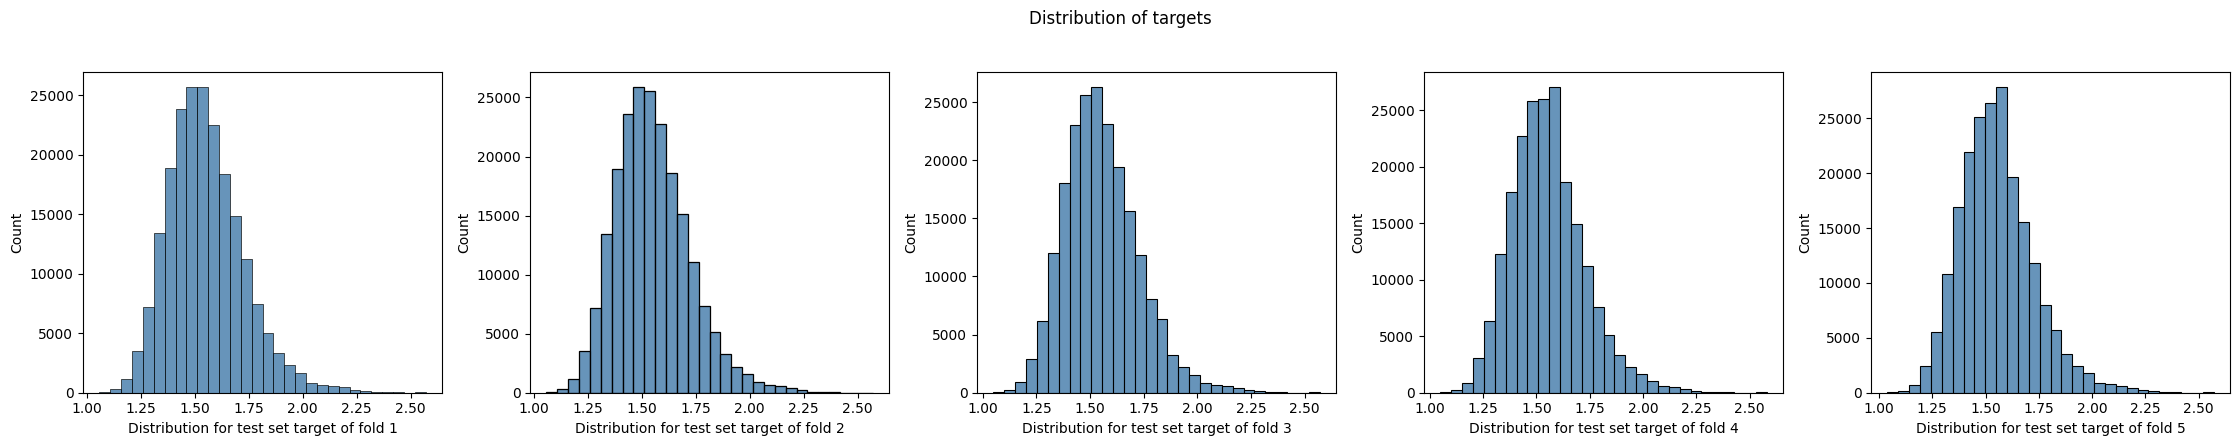

In [6]:
targets_test = pd.DataFrame(targets_test)
num_cols = targets_test.shape[1]

plt.figure(figsize=(num_cols * 4.5, 4.5))
plt.subplots_adjust(top=0.95, hspace=0.8, wspace=0.8)
plt.suptitle("Distribution of targets")

for n, feature in enumerate(targets_test.columns):
    # add a new subplot iteratively
    ax = plt.subplot(1, num_cols, n + 1)
    sns.histplot(
        data=targets_test,
        x=feature,
        bins=30,
        ax=ax,
        color="#3470a3",
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])

**Performance Analysis**

In [7]:
data_train, data_test = train_test_split(data_rogue_waves_class, stratify=data_rogue_waves_class[target_cat], train_size=0.80, random_state=seed)

data_train.reset_index(inplace=True, drop=True)
data_test.reset_index(inplace=True, drop=True)

X_train = data_train[features]
y_train = data_train[target]

In [8]:
# ElasticNet hyperparameters for best model
alpha = 0.0001	
l1_ratio = 0.1
max_iter = 5000
selection = "cyclic"
tol = 0.0001

scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)

start = time.time()
model = ElasticNet(random_state=seed, alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter, selection=selection, tol=tol)

model.fit(X_train_transformed, y_train)
end = time.time()
print(f"Time to fit the ElasticNet model: {end - start} seconds")

Time to fit the ElasticNet model: 2.107246160507202 seconds


In [9]:
# Random Forest hyperparameters for best model
criterion = "friedman_mse"
max_depth = 30
max_features = "sqrt"
max_samples = 0.5
min_samples_leaf = 1
n_estimators = 100

start = time.time()
model = RandomForestRegressor(random_state=seed, criterion=criterion, max_depth=max_depth, max_features=max_features, max_samples=max_samples, min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

model.fit(X_train, y_train)
end = time.time()
print(f"Time to fit the Random Forest model: {end - start} seconds")

Time to fit the Random Forest model: 105.41851711273193 seconds


In [10]:
# XGBoost hyperparameters for best model
colsample_bytree = 0.8
gamma = 0
learning_rate = 0.1
max_depth = 20
min_child_weight = 1
n_estimators = 100
reg_alpha = 0
reg_lambda = 1
subsample = 0.5

start = time.time()
model = XGBRegressor(random_state=seed, colsample_bytree=colsample_bytree, gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, min_child_weight=min_child_weight,
                         n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda, subsample=subsample)

model.fit(X_train, y_train)
end = time.time()
print(f"Time to fit the XG Boost model: {end - start} seconds")

Time to fit the XG Boost model: 17.069395780563354 seconds
